In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

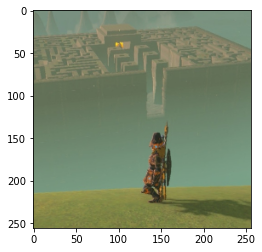

In [200]:
w, h = (256, 256)
#w, h = (128, 128)
path = '/Users/nicklatina/Desktop/CLIP Prompts/Labyrinth.JPG'
#path = '/Users/nicklatina/Desktop/CLIP Prompts/Prompt 49.jpg'

plt.figure()
img1 = cv2.imread(path)
img1 = cv2.resize(img1, (w, h))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
plt.imshow(img1)

In [201]:
x_coord, y_coord = np.meshgrid(range(w), range(h))
X = np.array(list(zip(x_coord.ravel(), y_coord.ravel()))) / max(w, h)
Y = img1.reshape(w*h,3) / 255.0

In [202]:
class FFNN:
    def __init__(self, layer_sizes, 
                 activation_fn, activation_fn_deriv, 
                 output_activation_fn, output_activation_fn_deriv, 
                 loss_fn, loss_fn_deriv, task_type='classification'):
        
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation_fn = activation_fn
        self.activation_fn_deriv = activation_fn_deriv
        self.output_activation_fn = output_activation_fn
        self.output_activation_fn_deriv = output_activation_fn_deriv
        self.loss_fn = loss_fn
        self.loss_fn_deriv = loss_fn_deriv
        self.task_type = task_type
        
        # Initialize weights and biases (He initialization)
        self.W = [np.random.randn(layer_sizes[i+1], layer_sizes[i]) * np.sqrt(2./layer_sizes[i]) 
                  for i in range(self.num_layers-1)]
        self.b = [np.random.randn(layer_sizes[i+1], 1)*0 for i in range(self.num_layers-1)]

    def forward(self, x):
        a = [x]
        z = []
        
        # Hidden layers
        for i in range(self.num_layers-2):
            z_i = self.W[i].dot(a[i]) + self.b[i]
            a_i = self.activation_fn(z_i)
            z.append(z_i)
            a.append(a_i)
        
        # Output layer
        z_out = self.W[-1].dot(a[-1]) + self.b[-1]
        a_out = self.output_activation_fn(z_out)
        z.append(z_out)
        a.append(a_out)
        
        return a_out, a, z
    
    def compute_loss(self, predictions, t):
        # Ensure the target shape matches the predictions
        if t.shape[0] != predictions.shape[0]:
            t = t.T
        return self.loss_fn(predictions, t)
    
    def _one_hot(self, inputs):
        n_values = len(np.unique(inputs))
        return np.eye(n_values)[:,inputs]
    
    def backward(self, x, t, a, z):
        m = x.shape[1]
        dL_dw = [np.zeros_like(w) for w in self.W]
        dL_db = [np.zeros_like(b) for b in self.b]
        
        # Ensure the target shape matches the predictions
        if t.shape[0] != a[-1].shape[0]:
            t = t.T
        
        dL_da = self.loss_fn_deriv(a[-1], t)
        dL_dz = dL_da * self.output_activation_fn_deriv(z[-1])
        
        dL_dw[-1] = dL_dz.dot(a[-2].T)
        dL_db[-1] = np.sum(dL_dz, axis=1, keepdims=True)
        
        for i in range(self.num_layers-3, -1, -1):
            dL_da = self.W[i+1].T.dot(dL_dz)
            dL_dz = dL_da * self.activation_fn_deriv(z[i])
            dL_dw[i] = dL_dz.dot(a[i].T)
            dL_db[i] = np.sum(dL_dz, axis=1, keepdims=True)
        
        return dL_dw, dL_db
    
    def update_weights(self, dL_dw, dL_db, learning_rate):
        self.W = [w - learning_rate * dw for w, dw in zip(self.W, dL_dw)]
        self.b = [b - learning_rate * db for b, db in zip(self.b, dL_db)]
        
    def train(self, X, labels, learning_rate=0.01, epochs=1000, batch_size=None):
        """Trains the neural network using the given training data and labels."""
        m = X.shape[1]

        for epoch in range(epochs):
            if batch_size:  # If batch size is specified, use mini-batch gradient descent
                num_batches = m // batch_size
                for batch in range(num_batches):
                    X_batch = X[:, batch*batch_size:(batch+1)*batch_size]
                    labels_batch = labels[batch*batch_size:(batch+1)*batch_size]

                    # Forward pass
                    predictions, a_batch, z_batch = self.forward(X_batch)
                    
                    # Backward pass
                    dL_dw, dL_db = self.backward(X_batch, labels_batch, a_batch, z_batch)

                    # Update weights and biases
                    self.update_weights(dL_dw, dL_db, learning_rate)
            else:  # Otherwise, use batch gradient descent
                # Forward pass
                predictions, a_full, z_full = self.forward(X)
                
                # Backward pass
                dL_dw, dL_db = self.backward(X, labels, a_full, z_full)

                # Update weights and biases
                self.update_weights(dL_dw, dL_db, learning_rate)

            # Print loss at the end of each 100 epochs:
            if epoch % 100 == 0:
                # Ensure activations are for the entire dataset
                predictions, _, _ = self.forward(X)
                loss = self.compute_loss(predictions, labels)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {np.mean(loss)}")

In [207]:
def ReLU(inputs):
    return np.maximum(inputs, 0)
def deriv_ReLU(Z):
    return Z>0

def sigmoid(inputs, clip_value=200):
    inputs = np.clip(inputs, -clip_value, clip_value)
    return 1 / (1 + np.exp(-inputs))

def deriv_sigmoid(inputs):
    outputs = sigmoid(inputs)
    return(outputs*(1-outputs))

def Linear(inputs):
    return (1/10)*inputs

def deriv_Linear(inputs):
    return inputs*0 + (1/10)

def clipped_ReLU(x, c=1):
    return np.minimum(np.maximum(0, x), c)

def deriv_clipped_ReLU(inputs):
    return (inputs>0) & (inputs<1)

def L2(outputs, targets):
    return 0.5*sum((outputs - targets)**2)

def deriv_L2(outputs, targets):
    return outputs - targets

def one_hot(inputs):
    n_values = np.max(inputs) + 1
    return np.eye(n_values)[:,inputs]

def softmax(Z):
    shiftZ = Z - np.max(Z, axis=0)
    exps = np.exp(shiftZ)
    return exps / np.sum(exps, axis=0)

def dummy_deriv_softmax(Z):
    return Z

def categorical_cross_entropy(predictions, labels):
    m = labels.shape[1]
    return -np.sum(np.log(predictions) * labels) / m

def deriv_cat_cross_entropy(predictions, labels):
    return predictions - labels  

In [178]:
pixels = np.random.choice(range(len(X)), size = int(len(X)*0.25), replace = False)
X_sample = X[pixels,:]
Y_sample = Y[pixels,:]

In [197]:
layer_sizes = [2,60,60,3]

ffnn = FFNN(layer_sizes = layer_sizes, 
                activation_fn = ReLU, 
                activation_fn_deriv = deriv_ReLU, 
                output_activation_fn = ReLU, 
                output_activation_fn_deriv = deriv_ReLU, 
                loss_fn = L2, 
                loss_fn_deriv = deriv_L2,
                task_type='regression')

ffnn.train(X.T, Y, learning_rate=0.004, epochs = 5000, batch_size=4000)

Epoch 1/5000 - Loss: 0.6365185417739658
Epoch 101/5000 - Loss: 0.007880304712977165
Epoch 201/5000 - Loss: 0.007337915798927022
Epoch 301/5000 - Loss: 0.007131594068115339
Epoch 401/5000 - Loss: 0.00655428749946815
Epoch 501/5000 - Loss: 0.007125831292396775
Epoch 601/5000 - Loss: 0.006292103180774168
Epoch 701/5000 - Loss: 0.0062235542383401125
Epoch 801/5000 - Loss: 0.006140750926058473
Epoch 901/5000 - Loss: 0.005969529612597993
Epoch 1001/5000 - Loss: 0.005787562434154501
Epoch 1101/5000 - Loss: 0.005526257286042304
Epoch 1201/5000 - Loss: 0.005462751057488875
Epoch 1301/5000 - Loss: 0.005332673809850908
Epoch 1401/5000 - Loss: 0.0050861280821533975
Epoch 1501/5000 - Loss: 0.004880512739058108
Epoch 1601/5000 - Loss: 0.0049050850590527835
Epoch 1701/5000 - Loss: 0.0046998214621308985
Epoch 1801/5000 - Loss: 0.004786879122556773
Epoch 1901/5000 - Loss: 0.004793471219144652
Epoch 2001/5000 - Loss: 0.004586776622188783
Epoch 2101/5000 - Loss: 0.004411670837153236
Epoch 2201/5000 - Los

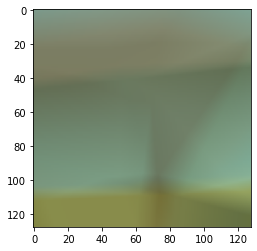

In [198]:
def viz(X, title, plot = True):
    pred,_,_ = ffnn.forward(X.T)
    # pred=pred.astype('int')
    predicted_image = pred.T.reshape(w, h, 3)
    predicted_image = (predicted_image * 255).astype(np.uint8)
    
    if plot:
        plt.imshow(predicted_image)
        
    predicted_image_bgr = cv2.cvtColor(predicted_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'/Users/nicklatina/Desktop/{title}.jpg', predicted_image_bgr)
viz(X, 'out')

In [208]:
'''epoch checkpoints'''
layer_sizes = [2,60,60,3]
ffnn = FFNN(layer_sizes = layer_sizes, 
                activation_fn = ReLU, 
                activation_fn_deriv = deriv_ReLU, 
                output_activation_fn = sigmoid, 
                output_activation_fn_deriv = deriv_sigmoid, 
                loss_fn = L2, 
                loss_fn_deriv = deriv_L2,
                task_type='regression')

checkpoints = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 22, 25, 30, 35, 40, 45, 50, 70, 85, 100, 150, 200, 250, 300, 350, 400, 450, 500, 575, 650, 725, 800, 875, 950, 1025, 1100, 1200, 1300, 1500, 1700, 2000, 2300, 2600, 2900, 3400, 3700, 4100, 4500, 5000, 5500, 6000]####
for i in range(len(checkpoints)-1):
    epochs = checkpoints[i+1] - checkpoints[i]
    ffnn.train(X.T, Y, learning_rate=0.001, epochs = epochs, batch_size=15000)
    viz(X, f'Lab(60_60_ReLU_sig_out)/img_{i + 1000}_epoch_{checkpoints[i]}', plot = False)
    

Epoch 1/1 - Loss: 0.3037431680162676
Epoch 1/1 - Loss: 0.10280178119760353
Epoch 1/1 - Loss: 0.00896181085762966
Epoch 1/1 - Loss: 0.008682357169458373
Epoch 1/1 - Loss: 0.008587385211765329
Epoch 1/1 - Loss: 0.00856443597776019
Epoch 1/1 - Loss: 0.00847134247851258
Epoch 1/1 - Loss: 0.008448865200227047
Epoch 1/1 - Loss: 0.008426185031157015
Epoch 1/1 - Loss: 0.008395828565733364
Epoch 1/1 - Loss: 0.008375999037180379
Epoch 1/1 - Loss: 0.008357546644134581
Epoch 1/3 - Loss: 0.008311681730290423
Epoch 1/3 - Loss: 0.008260207076546894
Epoch 1/4 - Loss: 0.008478819769269848
Epoch 1/3 - Loss: 0.015294000140429823
Epoch 1/5 - Loss: 0.008603896657260421
Epoch 1/5 - Loss: 0.014143763404651434
Epoch 1/5 - Loss: 0.006952095948133162
Epoch 1/5 - Loss: 0.006717811636969763
Epoch 1/5 - Loss: 0.008593551627998072
Epoch 1/20 - Loss: 0.007613935008743926
Epoch 1/15 - Loss: 0.007170381725493006
Epoch 1/15 - Loss: 0.007525455626052417
Epoch 1/50 - Loss: 0.01233675605091871
Epoch 1/50 - Loss: 0.0071574